In [1]:
from experimental import ExperimentalInitialBeam, NonparametricTransformLReLU
import torch

defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}
transformer = NonparametricTransformLReLU(4,6)
beam_gen = ExperimentalInitialBeam(100000, transformer, **defaults)

initial_beam = beam_gen()

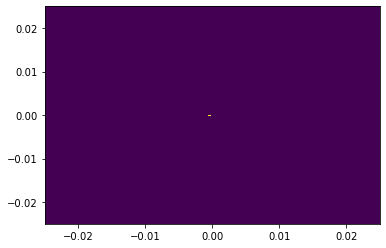

In [2]:
import matplotlib.pyplot as plt
from visualization import add_image
fig,ax = plt.subplots()
bins = torch.linspace(-25,25,150)*1e-3
add_image(ax,"x","y", [initial_beam],bins);


(array([6.2000e+01, 6.0100e+02, 3.3560e+03, 1.1038e+04, 2.2945e+04,
        3.6955e+04, 1.9169e+04, 5.2650e+03, 5.7700e+02, 3.2000e+01]),
 array([-0.00023642, -0.00022727, -0.00021812, -0.00020897, -0.00019982,
        -0.00019067, -0.00018151, -0.00017236, -0.00016321, -0.00015406,
        -0.00014491], dtype=float32),
 <BarContainer object of 10 artists>)

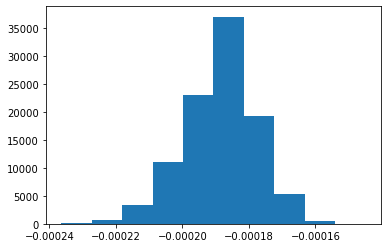

In [3]:
plt.hist(initial_beam.x.detach().numpy())

In [4]:
# precondition the transformer
from tqdm import trange

def BeamPosLoss(out_beam):
    return torch.mean(out_beam.data)**2

def BeamStdLoss(out_beam, target_std):
    std = (torch.std(out_beam.data) - target_std)**2
    return std.sqrt()

def BeamLoss(out_beam, target_beam):
    return torch.std(out_beam.data - target_beam*1e-3)

def TargetNLL(out_beam):
    dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)*1e-6)
    return -dist.log_prob(out_beam.data).sum()

transformer = NonparametricTransformLReLU(2,10)
model = ExperimentalInitialBeam(10000, transformer, **defaults)
optim = torch.optim.Adam(model.transformer.parameters(), lr=0.01)
n_iter = 1000
losses = []

for i in trange(n_iter):
    optim.zero_grad(set_to_none=True)

    output_beam = model()
    #beam_pos_loss = BeamPosLoss(output_beam)
    #beam_size_loss = BeamStdLoss(output_beam, torch.tensor(1.0e-2))*1e3
    #loss = beam_pos_loss + beam_size_loss
    loss = BeamLoss(output_beam, model.base_distribution_samples)

    #losses += [[beam_pos_loss.cpu().detach(), beam_size_loss.cpu().detach()]]
    losses += [loss.cpu().detach()]
    loss.backward()

    optim.step()
losses = torch.tensor(losses)

100%|██████████| 1000/1000 [00:02<00:00, 414.94it/s]


torch.Size([1000])


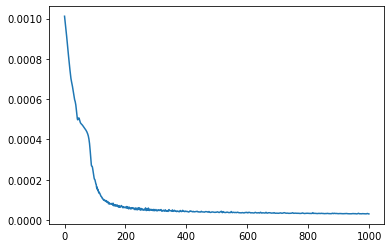

In [5]:
print(losses.shape)
plt.plot(losses)
#plt.plot(losses[1])

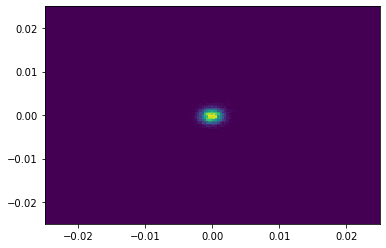

In [6]:
fig,ax = plt.subplots()
bins = torch.linspace(-25,25,150)*1e-3
#add_image(ax,"x","y", [model()],bins);
add_image(ax,"x","yp", [model()],bins);

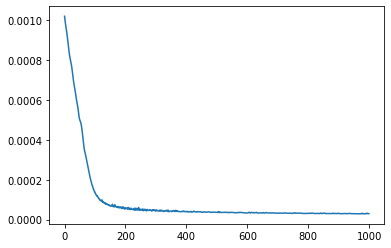

conditioning loss: 2.992857844219543e-05


In [7]:
from experimental import condition_initial_beam
transformer = NonparametricTransformLReLU(2,10)
model = ExperimentalInitialBeam(10000, transformer, **defaults)
model = condition_initial_beam(model)

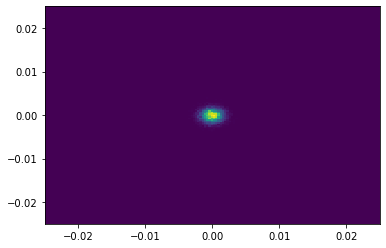

In [8]:
fig,ax = plt.subplots()
bins = torch.linspace(-25,25,150)*1e-3
#add_image(ax,"x","y", [model()],bins);
add_image(ax,"x","yp", [model()],bins);